# Projeto Final - Tera - Data Science
Notebooks destinados ao desenvolvimento do projeto final do treinamento Tera - Data Science
## Forecasting
1. Objetivo:
    1. Prever o desempenho do faturamento por loja para definição do baseline
2. Output:
    1. DataSet com as previsões de faturamento por loja

In [45]:
!pip install xgboost


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
# Bibliotecas Padrões
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Bibliotecas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
print("xgboost", xgboost.__version__)

xgboost 1.7.3


In [47]:
df_model = pd.read_csv('../data/intermediate/df_model.csv', sep=';')
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model

,Date,Store,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,Size,Type
0,2010-02-05,1,0,1643690.90,42.31,2.572,151315,3
1,2010-02-05,2,0,2136989.46,40.19,2.572,202307,3
2,2010-02-05,3,0,461622.22,45.71,2.572,37392,2
3,2010-02-05,4,0,2135143.87,43.76,2.598,205863,3
4,2010-02-05,5,0,317173.10,39.70,2.572,34875,2
...,...,...,...,...,...,...,...,...
6430,2012-10-26,41,0,1316542.59,41.80,3.686,196321,3
6431,2012-10-26,42,0,514756.08,70.50,4.301,39690,1
6432,2012-10-26,43,0,587603.55,69.17,3.506,41062,1
6433,2012-10-26,44,0,361067.07,46.97,3.755,39910,1


In [48]:
# define model
model = XGBRegressor()

In [49]:
split_date = '01-01-2012'

df_train = df_model[df_model.Date < split_date].copy()
df_train['Date'] = pd.to_datetime(df_train['Date'])

df_test = df_model[df_model.Date >= split_date].copy()
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [50]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.Date
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [51]:
X_train, y_train = create_features(df_train, label='Weekly_Sales')
X_test, y_test = create_features(df_test, label='Weekly_Sales')

<ipython-input-50-b0211dbfc50e>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [52]:
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:930848.45937	validation_1-rmse:906296.19075
[1]	validation_0-rmse:764838.25269	validation_1-rmse:745254.97138
[2]	validation_0-rmse:668254.52603	validation_1-rmse:650236.53747
[3]	validation_0-rmse:615226.58754	validation_1-rmse:597162.32535
[4]	validation_0-rmse:587302.16556	validation_1-rmse:568247.64854
[5]	validation_0-rmse:573065.26655	validation_1-rmse:553022.11139
[6]	validation_0-rmse:565889.82677	validation_1-rmse:545069.91450
[7]	validation_0-rmse:562319.48569	validation_1-rmse:540917.02572
[8]	validation_0-rmse:560524.11267	validation_1-rmse:538586.34602
[9]	validation_0-rmse:559604.24488	validation_1-rmse:537263.20215
[10]	validation_0-rmse:559141.72182	validation_1-rmse:536578.10386
[11]	validation_0-rmse:558916.24113	validation_1-rmse:536082.63352
[12]	validation_0-rmse:558803.64367	validation_1-rmse:535808.20673
[13]	validation_0-rmse:558737.53993	validation_1-rmse:535639.66199
[14]	validation_0-rmse:558706.52230	validation_1-rmse:535530.21640
[15]	

c:\Users\Pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-rmse:558659.90755	validation_1-rmse:535373.34556
[23]	validation_0-rmse:558659.28900	validation_1-rmse:535374.66424
[24]	validation_0-rmse:558659.05448	validation_1-rmse:535373.15312
[25]	validation_0-rmse:558658.94791	validation_1-rmse:535375.63935
[26]	validation_0-rmse:558658.83652	validation_1-rmse:535375.19435
[27]	validation_0-rmse:558658.64381	validation_1-rmse:535378.44683
[28]	validation_0-rmse:558658.49445	validation_1-rmse:535380.21014
[29]	validation_0-rmse:558658.41720	validation_1-rmse:535382.89531
[30]	validation_0-rmse:558658.34217	validation_1-rmse:535385.53669
[31]	validation_0-rmse:558658.29447	validation_1-rmse:535386.78378
[32]	validation_0-rmse:558658.26473	validation_1-rmse:535387.06986
[33]	validation_0-rmse:558658.24486	validation_1-rmse:535387.02581
[34]	validation_0-rmse:558658.23264	validation_1-rmse:535389.08699
[35]	validation_0-rmse:558658.22002	validation_1-rmse:535390.06352
[36]	validation_0-rmse:558658.21189	validation_1-rmse:535390.4

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

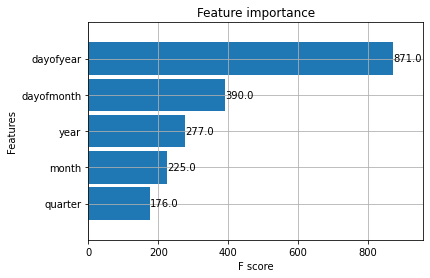

In [53]:
_ = xgb.plot_importance(reg, height=0.9)

In [54]:
df_test['Weekly_Sales_Predicted'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

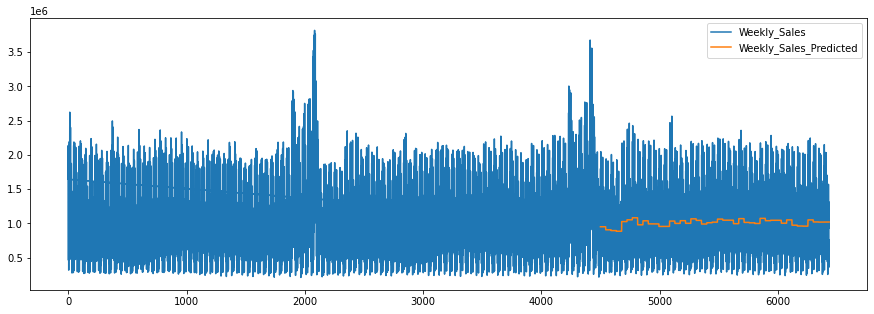

In [55]:
_ = df_all[['Weekly_Sales','Weekly_Sales_Predicted']].plot(figsize=(15, 5))

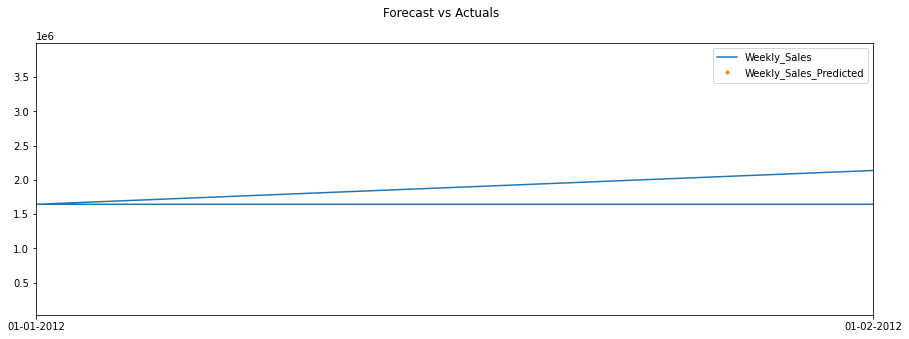

In [56]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Weekly_Sales','Weekly_Sales_Predicted']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2012', upper='01-02-2012')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals')

In [57]:
mean_squared_error(y_true=df_test['Weekly_Sales'],
                   y_pred=df_test['Weekly_Sales_Predicted'])

286624411775.5044

In [58]:
mean_absolute_error(y_true=df_test['Weekly_Sales'],
                   y_pred=df_test['Weekly_Sales_Predicted'])

450157.8406860465

In [59]:
r2_score(y_true=df_test['Weekly_Sales'],
                   y_pred=df_test['Weekly_Sales_Predicted'])

0.004251145904118014

In [60]:
df_all

,Date,Store,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,Size,Type,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Weekly_Sales_Predicted
4500,2012-01-06,1,0,1550369.92,49.01,3.157,151315,3,2012-01-06,0,4,1,1,2012,6,6,1,950371.5
4501,2012-01-06,2,0,1799520.14,46.75,3.157,202307,3,2012-01-06,0,4,1,1,2012,6,6,1,950371.5
4502,2012-01-06,3,0,398178.21,52.42,3.157,37392,2,2012-01-06,0,4,1,1,2012,6,6,1,950371.5
4503,2012-01-06,4,0,2047766.07,38.64,3.158,205863,3,2012-01-06,0,4,1,1,2012,6,6,1,950371.5
4504,2012-01-06,5,0,312078.71,50.21,3.157,34875,2,2012-01-06,0,4,1,1,2012,6,6,1,950371.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,2011-12-30,41,1,1264014.16,34.12,3.119,196321,3,2011-12-30,0,4,4,12,2011,364,30,52,NaN
4496,2011-12-30,42,1,454412.28,48.92,3.428,39690,1,2011-12-30,0,4,4,12,2011,364,30,52,NaN
4497,2011-12-30,43,1,505405.85,41.83,3.129,41062,1,2011-12-30,0,4,4,12,2011,364,30,52,NaN
4498,2011-12-30,44,1,263917.85,31.53,3.119,39910,1,2011-12-30,0,4,4,12,2011,364,30,52,NaN


In [61]:
df_all.to_csv('../data/processed/df_predicted.csv', index=False, sep=';')